# 1. Importing libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# 2. Data download and performing initial setup

In [ ]:
# Using kaggle.json (api method) file to directly download data to google colab
files.upload()
# Requirement for downloading data directly to google colab
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# Downloading data to google colab
!kaggle competitions download -c elo-merchant-category-recommendation
# unzipping the required files
!unzip new_merchant_transactions.csv.zip
!unzip sample_submission.csv.zip
!unzip merchants.csv.zip
!unzip test.csv.zip
!unzip train.csv.zip
!unzip historical_transactions.csv.zip
# Deleting useless old zip files
!rm new_merchant_transactions.csv.zip
!rm sample_submission.csv.zip
!rm merchants.csv.zip
!rm test.csv.zip
!rm train.csv.zip
!rm historical_transactions.csv.zip

In [3]:
# Reading all the data that is being provided
data_dict = pd.read_excel('Data_Dictionary.xlsx')
hist_data = pd.read_csv('historical_transactions.csv')
merchants_data = pd.read_csv('merchants.csv')
merchants_transaction = pd.read_csv('new_merchant_transactions.csv')
sample_sub = pd.read_csv('sample_submission.csv')
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [4]:
# Using the below function for memory optimization so that space can be utilized in better way
# Taken from https://www.kaggle.com/rinnqd/reduce-memory-usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


In [5]:
# Applying the above function to each dataframe
data_dict = reduce_mem_usage(data_dict)
hist_data = reduce_mem_usage(hist_data)
merchants_data = reduce_mem_usage(merchants_data)
merchants_transaction = reduce_mem_usage(merchants_transaction)
sample_sub = reduce_mem_usage(sample_sub)
train_data = reduce_mem_usage(train_data)
test_data = reduce_mem_usage(test_data)

Memory usage after optimization is: 0.00 MB
Decreased by 0.0%
Memory usage after optimization is: 1749.11 MB
Decreased by 43.7%
Memory usage after optimization is: 30.32 MB
Decreased by 46.0%
Memory usage after optimization is: 114.20 MB
Decreased by 45.5%
Memory usage after optimization is: 1.06 MB
Decreased by 43.7%
Memory usage after optimization is: 4.04 MB
Decreased by 56.2%
Memory usage after optimization is: 2.24 MB
Decreased by 52.5%


# 3. Exploratory data Analysis(Eda)

## 3.1 Train data and Test data

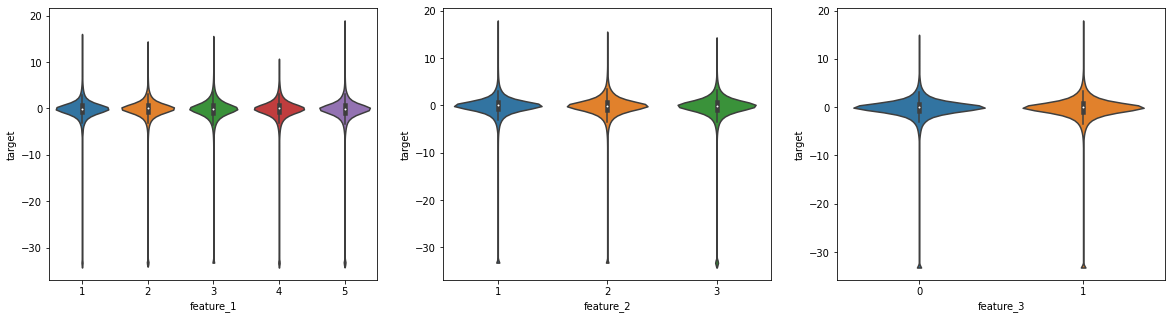

In [ ]:
# Lets see for feature_1,feature_2 and feature_3 
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(20,5))
sns.violinplot(x='feature_1',y='target',data=train_data,ax=ax[0])
sns.violinplot(x='feature_2',y='target',data=train_data,ax=ax[1])
sns.violinplot(x='feature_3',y='target',data=train_data,ax=ax[2])
plt.show()

As you can see in the above that for all three features the target is not being distinguished by them even the class for each features are even overlapping.so from this it can be understood that more features are needed.

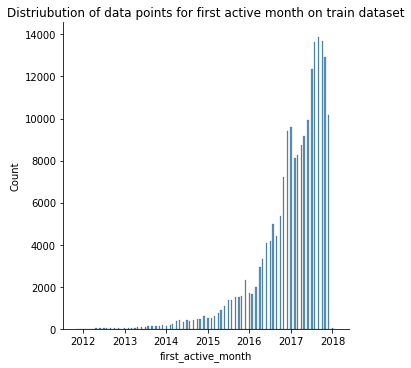

In [85]:
# Lets see the date feature
# First of all it need to converted to datetime object to make it usable
train_data['first_active_month'] = pd.to_datetime(train_data['first_active_month'])
sns.displot(data= pd.to_datetime(train_data['first_active_month']))
plt.title('Distriubution of data points for first active month on train dataset')
plt.show()

it can be seen that the points lies between 2012 to 2018 with latest time having higher number of datapoints

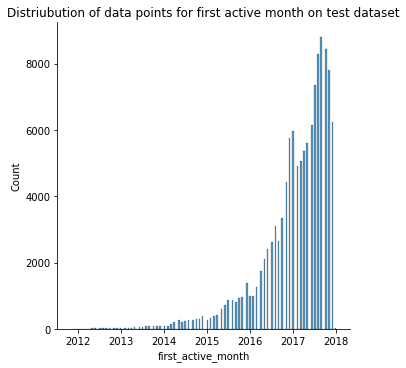

In [86]:
# Lets see the same graph as above one for test data
test_data['first_active_month'] = pd.to_datetime(test_data['first_active_month'])
sns.displot(data= pd.to_datetime(test_data['first_active_month']))
plt.title('Distriubution of data points for first active month on test dataset')
plt.show()

same pattern observed here as above i.e there are more points in range 2016 to 2018

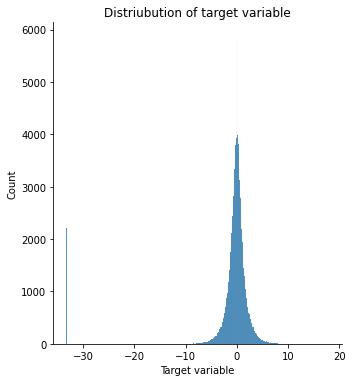

In [87]:
# Now lets see for the target variable
sns.displot(train_data['target'].values)
plt.title('Distriubution of target variable')
plt.xlabel('Target variable')
plt.show()

as it can be seen that most of the values of y_target lies between -10 and 10 others are outliers.But also one thing to observe is that there are approximaltely 2000 points in the range of -30 to -34.

In [ ]:
train_data['target'][(train_data['target']<-10) | (train_data['target']>10)].value_counts().values.sum()

2311

so as you can see that there are 2311 extreme data points(outliers) for target variable

## 3.2 Historical data

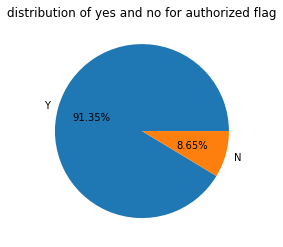

In [ ]:
# Lets see the distribution of yes and no for the authorized flag
data = hist_data['authorized_flag'].value_counts().values
labels = hist_data['authorized_flag'].value_counts().index
plt.pie(data, labels = labels, autopct='%.2f%%')
plt.title('distribution of yes and no for authorized flag')
plt.show()

In [ ]:
# Converting the authorized flag to 0 and 1 from y and n
hist_data['authorized_flag'].replace('Y',1,inplace=True)
hist_data['authorized_flag'].replace('N',0,inplace=True)


this means imbalance class distribution

In [ ]:
hist_data.groupby(['card_id'])['authorized_flag'].agg(['mean'])

,mean
card_id,
C_ID_00007093c1,0.765101
C_ID_0001238066,0.975610
C_ID_0001506ef0,0.939394
C_ID_0001793786,0.875000
C_ID_000183fdda,0.951389
...,...
C_ID_ffff1d9928,0.750000
C_ID_ffff579d3a,0.868421
C_ID_ffff756266,0.583333


The above show the percentage of acceptance based on card id that what percent is it authorized

In [ ]:
print('There are {} unique cities '.format(len(hist_data['city_id'].unique())))

There are 308 unique cities 


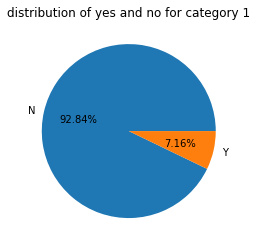

In [ ]:
data = hist_data['category_1'].value_counts().values
labels = hist_data['category_1'].value_counts().index
plt.pie(data, labels = labels, autopct='%.2f%%')
plt.title('distribution of yes and no for category 1')
plt.show()

Here is also imbalance class distribution

In [ ]:
hist_data['category_1'].replace('Y',1,inplace=True)
hist_data['category_1'].replace('N',0,inplace=True)


In [ ]:
hist_data.groupby(['category_1'])['authorized_flag'].agg(['mean'])

,mean
category_1,
0,0.926265
1,0.748578


As it can be seen that for category 0 sucess rate is 92% and for category 1 sucesss rate is 74%

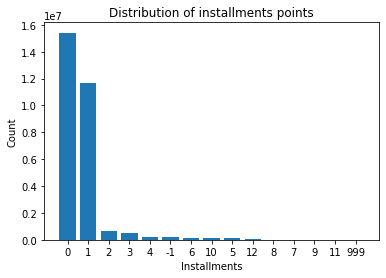

In [88]:
plt.bar(x=hist_data['installments'].value_counts().index.astype('str'),height=hist_data['installments'].value_counts().values)
plt.xlabel('Installments')
plt.ylabel('Count')
plt.title('Distribution of installments points')
plt.show()

As it can be seen in the above graph that most of the values are 0 and 1 and other values are very less in number.

In [ ]:
hist_data.groupby(['installments'])['authorized_flag'].agg(['mean'])

,mean
installments,
-1,0.885692
0,0.928032
1,0.907024
2,0.884020
3,0.862254
4,0.819903
5,0.809183
6,0.779732
7,0.693196


As you can see in the above table the sucess rate for each class of installment for authorized_flag

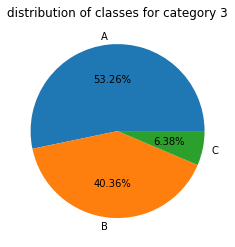

In [ ]:
# Finding the distribution of classes in category 3
data = hist_data['category_3'].value_counts().values
labels = hist_data['category_3'].value_counts().index
plt.pie(data, labels = labels, autopct='%.2f%%')
plt.title('distribution of classes for category 3')
plt.show()

It can be seen from the data that C class datapoints are lowest in number.

In [ ]:
#Now lets see authorized flag percentage for all classes
hist_data['category_3'].replace('A',1,inplace=True)
hist_data['category_3'].replace('B',2,inplace=True)
hist_data['category_3'].replace('C',3,inplace=True)

hist_data.groupby(['category_3'])['authorized_flag'].agg(['mean','median'])

,mean,median
category_3,,
1.0,0.928032,1
2.0,0.907024,1
3.0,0.836498,1


As it can be seen in the above table the sucess rate of class A is 92% ,class B it is 90% and for class C it is 83%

In [ ]:
# Lets see how many unqiue cities are there
print('There are {} unique cities '.format(len(hist_data['merchant_category_id'].unique())))

There are 327 unique cities 


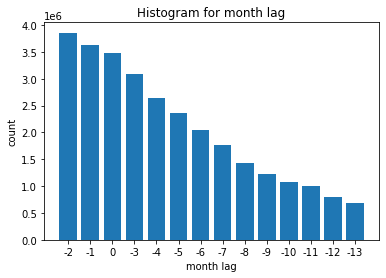

In [90]:
# Lets find out distribution of classes in month lag
plt.bar(x=hist_data['month_lag'].value_counts().index.astype('str'),height=hist_data['month_lag'].value_counts().values)
plt.xlabel('month lag')
plt.ylabel('count')
plt.title('Histogram for month lag')
plt.show()

This above graph really looks cool that month lag for all cases are approximately in balanced format

In [ ]:
print('There are {} unique merchants category ids'.format(len(hist_data['merchant_category_id'].unique())))

There are 327 unique merchants category ids


In [ ]:
# Lets find out the genuinity for merchants category ids
hist_data.groupby(['merchant_category_id'])['authorized_flag'].agg(['mean','median','min','max']).sort_values(by='mean')

,mean,median,min,max
merchant_category_id,,,,
59,0.285714,0.0,0,1
31,0.345455,0.0,0,1
141,0.366559,0.0,0,1
53,0.414249,0.0,0,1
109,0.477157,0.0,0,1
...,...,...,...,...
687,1.000000,1.0,1,1
164,1.000000,1.0,1,1
37,1.000000,1.0,1,1


we can see that genuity based on category id starting at lowest from 28% to highest 100%

In [ ]:
print('There are {} unique merchants ids'.format(len(hist_data['merchant_id'].unique())))

There are 326312 unique merchants ids


In [ ]:
# Lets see their authencity based on previous record
hist_data.groupby(['merchant_id'])['authorized_flag'].agg(['mean']).sort_values(by='mean')

,mean
merchant_id,
M_ID_d85500250a,0.0
M_ID_f0aea19030,0.0
M_ID_bef642c550,0.0
M_ID_caa8094176,0.0
M_ID_01dc7ed241,0.0
...,...
M_ID_217096c999,1.0
M_ID_8f4d2a8ec4,1.0
M_ID_8f4d3b1284,1.0


lowest ones are with zero percentage and highest ones are with higher percentages

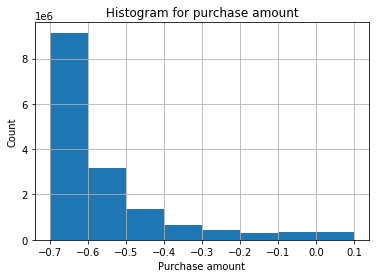

In [91]:
hist_data['purchase_amount'].hist(bins=[-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.1])
plt.xlabel('Purchase amount')
plt.ylabel('Count')
plt.title('Histogram for purchase amount')
plt.show()

As it can be seen in the histogram that majority of amount lies in negative ranges and very less above in positive ranges.

In [84]:
# Lets see how many points are negative.
print('There are {} values which are negative'.format(np.sum(hist_data['purchase_amount']<0)))

There are 28036884 values which are negative


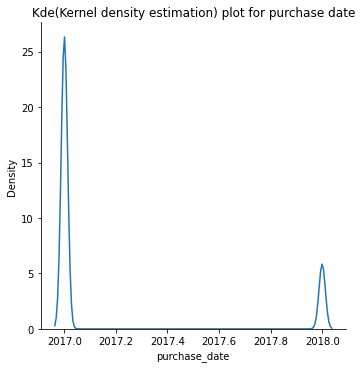

In [93]:
# Now lets see purchase date feature
sns.displot(pd.to_datetime(hist_data['purchase_date']).dt.year,kind='kde')
plt.title('Kde(Kernel density estimation) plot for purchase date')
plt.show()

As you can see in graph the distribution of the data across time axis

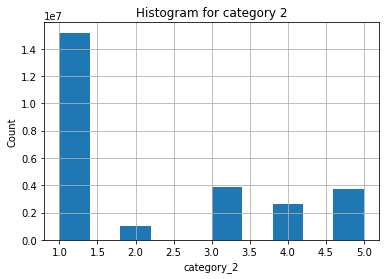

In [95]:
# Lets see the distribution of classes in category_2
hist_data['category_2'].hist()
plt.xlabel('category_2')
plt.ylabel('Count')
plt.title('Histogram for category 2')
plt.show() 

In [96]:
# Let's check if there are nan values or not
print('There are {} nan values in the category_2 column'.format(np.sum(np.isnan(hist_data['category_2'].values))))

There are 2652864 nan values in the category_2 column


which are to much empty values.

In [100]:
print('There are {} unique state id'.format(len(hist_data['state_id'].unique())))
print('There are {} unique subsector id'.format(len(hist_data['subsector_id'].unique())))

There are 25 unique state id
There are 41 unique subsector id


##3.3 Merchants data

In [17]:
print('There are {} unique merchants groups'.format(len(merchants_data['merchant_group_id'].unique())))
print('There are {} unique merchants categories'.format(len(merchants_data['merchant_category_id'].unique())))
print('There are {} unique merchants subsectors'.format(len(merchants_data['subsector_id'].unique())))
print('There are {} unique cities'.format(len(merchants_data['city_id'].unique())))


There are 109391 unique merchants groups
There are 324 unique merchants categories
There are 41 unique merchants subsectors
There are 271 unique cities


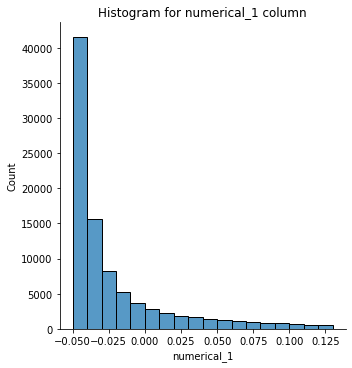

In [96]:
# Lets see the distribution of values in numerical 1 column
bins_list = []
k=-0.05
while k<0.13:
  bins_list.append(k)
  k+=0.01
sns.displot(merchants_data['numerical_1'],bins=bins_list)
plt.title('Histogram for numerical_1 column')
plt.show()

As it can be seen in the above figure that most of the values are negative and some are postive .

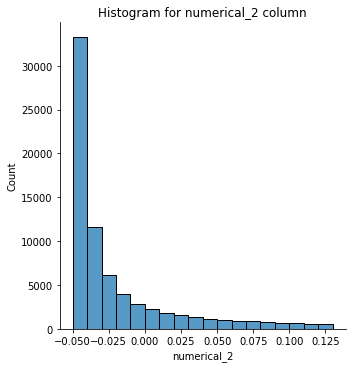

In [97]:
# Lets see the distribution of values in numerical 2 column
bins_list = []
k=-0.05
while k<0.13:
  bins_list.append(k)
  k+=0.01
sns.displot(merchants_data['numerical_2'],bins=bins_list)
plt.title('Histogram for numerical_2 column')
plt.show()

same as the above one 

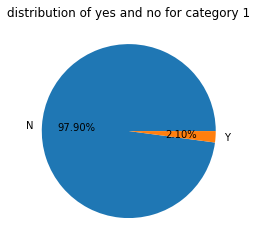

In [39]:
# Lets see rhe distribution of yes and no for category 1
data = merchants_data['category_1'].value_counts().values
labels = merchants_data['category_1'].value_counts().index
plt.pie(data, labels = labels, autopct='%.2f%%')
plt.title('distribution of yes and no for category 1')
plt.show()

it can be seen that it is highly imbalanced yes only consist of 2.1% of whole data

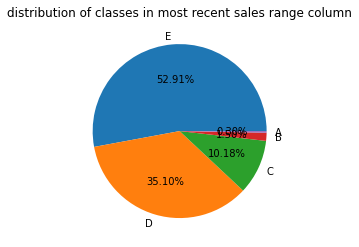

In [42]:
# Lets see the distribution of the classes in most recent sales range
data = merchants_data['most_recent_sales_range'].value_counts().values
labels = merchants_data['most_recent_sales_range'].value_counts().index
plt.pie(data, labels = labels, autopct='%.2f%%')
plt.title('distribution of classes in most recent sales range column')
plt.show()

As it can that class a and b are very less in number c,d,e are in the balanced range.

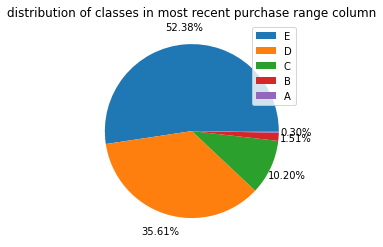

In [42]:
# Lets see the distribution of the classes in most recent purchase range
data = merchants_data['most_recent_purchases_range'].value_counts().values
labels = merchants_data['most_recent_purchases_range'].value_counts().index
plt.pie(data, autopct='%.2f%%',pctdistance=1.2,labeldistance=5)
plt.legend(labels=labels)
plt.title('distribution of classes in most recent purchase range column')
plt.show()

The same pattern in observed in purchases as sales range

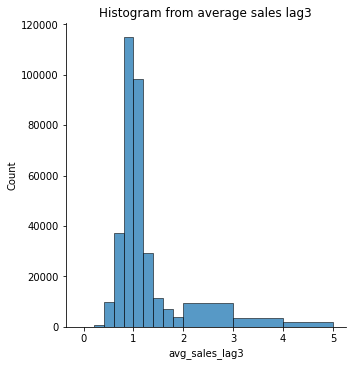

In [98]:
# Lets find out the distribution of the avg_sales_lag3 data points
sns.displot(merchants_data['avg_sales_lag3'],bins=[-0.1,0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2,3,4,5])
plt.title('Histogram from average sales lag3')
plt.show()

As it can be seen in the above graph that majority of points lies between 0 and 2 for average sales lag for quarter 3

In [30]:
# Lets check if there are any nan values and find out minimum and maximum values
print('There are {} nan values in average_lag_3'.format(np.sum(np.isnan(merchants_data['avg_sales_lag3']))))
print('The minimum value for average_sales_lag_3 is {}'.format(merchants_data['avg_sales_lag3'].min()))
print('The maximum value for average_sales_lag_3 is {}'.format(merchants_data['avg_sales_lag3'].max()))

There are 13 nan values in average_lag_3
The minimum value for average_sales_lag_3 is -82.12999725341797
The maximum value for average_sales_lag_3 is 851844.625


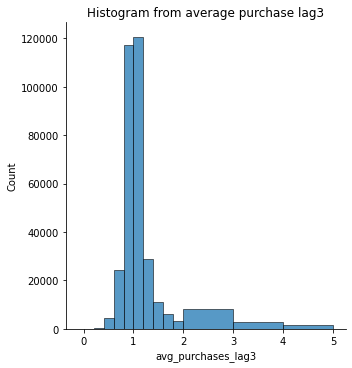

In [99]:
# Lets find out the distribution of the avg_purchase_lag3 data points
sns.displot(merchants_data['avg_purchases_lag3'],bins=[-0.1,0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2,3,4,5])
plt.title('Histogram from average purchase lag3')
plt.show()

As it can be seen in the above graph that majority of points lies between 0 and 2 for average purchase lag for quarter 3

In [48]:
# Lets check if there are any nan values and find out minimum and maximum values
print('There are {} nan values in average_lag_3'.format(np.sum(np.isnan(merchants_data['avg_purchases_lag3']))))
print('The minimum value for average_purchase_lag_3 is {}'.format(merchants_data['avg_purchases_lag3'].min()))
print('The maximum value for average_purchase_lag_3 is {}'.format(merchants_data['avg_purchases_lag3'].max()))

There are 0 nan values in average_lag_3
The minimum value for average_purchase_lag_3 is 0.33349533
The maximum value for average_purchase_lag_3 is inf


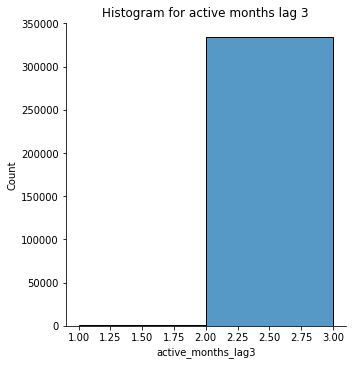

In [100]:
sns.displot(merchants_data['active_months_lag3'],bins=[1,2,3])
plt.title('Histogram for active months lag 3')
plt.show()

In [61]:
# Lets find out the percentage of points for class 3
temp = merchants_data['active_months_lag3'].value_counts()
percentage = temp[3]/(temp[1]+temp[2]+temp[3])*100
print('There are {:.2f}% of points for class 3'.format(percentage))

There are 99.57% of points for class 3


In [62]:
# Lets check if there are any nan values and find out minimum and maximum values
print('There are {} nan values in average_lag_3'.format(np.sum(np.isnan(merchants_data['active_months_lag3']))))
print('The minimum value for average_purchase_lag_3 is {}'.format(merchants_data['active_months_lag3'].min()))
print('The maximum value for average_purchase_lag_3 is {}'.format(merchants_data['active_months_lag3'].max()))

There are 0 nan values in average_lag_3
The minimum value for average_purchase_lag_3 is 1
The maximum value for average_purchase_lag_3 is 3


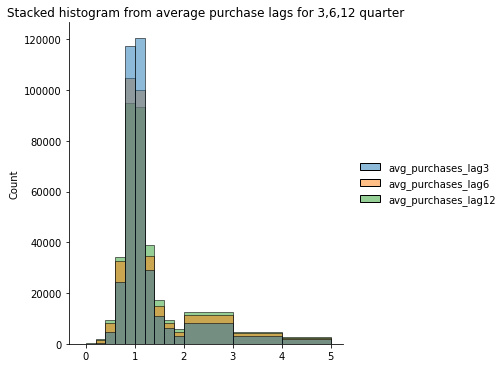

In [101]:
# Let's see the avg purchase lags for all the three quarters
sns.displot(merchants_data[['avg_purchases_lag3','avg_purchases_lag6','avg_purchases_lag12']],bins=[-0.1,0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2,3,4,5])
plt.title('Stacked histogram from average purchase lags for 3,6,12 quarter')
plt.show()

The purchase record for all the three quarter is almost in the same range only

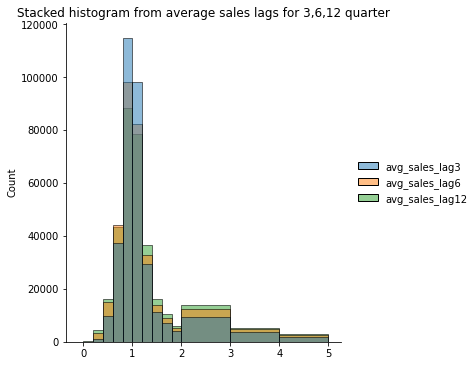

In [102]:
# Let's see the avg sales lags for all the three quarters
sns.displot(merchants_data[['avg_sales_lag3','avg_sales_lag6','avg_sales_lag12']],bins=[-0.1,0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2,3,4,5],legend=True)
plt.title('Stacked histogram from average sales lags for 3,6,12 quarter')
plt.show()

The sales record for all the three quarter is almost in the same range only

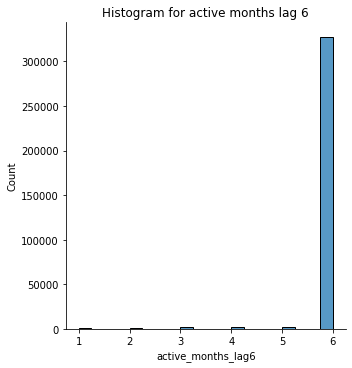

In [103]:
# Lets see for the active months lag_6
sns.displot(merchants_data['active_months_lag6'])
plt.title('Histogram for active months lag 6')
plt.show()

data for point 6 is almost max than all others

In [73]:
# Lets find out the percentage of points for class 6
temp = merchants_data['active_months_lag6'].value_counts()
percentage = temp[6]/(temp[1]+temp[2]+temp[3]+temp[4]+temp[5]+temp[6])*100
print('There are {:.2f}% of points for class 6 in active month lag_6'.format(percentage))

There are 97.79% of points for class 6 in active month lag_6


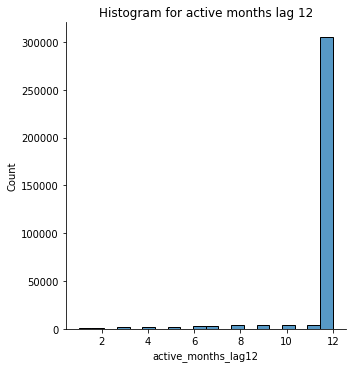

In [104]:
# Lets see for the active months lag_12
sns.displot(merchants_data['active_months_lag12'])
plt.title('Histogram for active months lag 12')
plt.show()

In [81]:
# Lets find out the percentage of points for class 12
temp = merchants_data['active_months_lag12'].value_counts()
percentage = temp[12]/(np.sum(temp.values))*100
print('There are {:.2f}% of points for class 12 in active month lag_12'.format(percentage))

There are 91.16% of points for class 12 in active month lag_12


In [82]:
# Lets check if there are any nan values and find out minimum and maximum values for avg_sales_lag6
print('There are {} nan values in average_lag_6'.format(np.sum(np.isnan(merchants_data['avg_purchases_lag6']))))
print('The minimum value for average_purchase_lag_6 is {}'.format(merchants_data['avg_purchases_lag6'].min()))
print('The maximum value for average_purchase_lag_6 is {}'.format(merchants_data['avg_purchases_lag6'].max()))
# Lets check if there are any nan values and find out minimum and maximum values for avg_sales_lag12
print('There are {} nan values in average_lag_12'.format(np.sum(np.isnan(merchants_data['avg_purchases_lag12']))))
print('The minimum value for average_purchase_lag_12 is {}'.format(merchants_data['avg_purchases_lag12'].min()))
print('The maximum value for average_purchase_lag_12 is {}'.format(merchants_data['avg_purchases_lag12'].max()))

There are 0 nan values in average_lag_6
The minimum value for average_purchase_lag_6 is 0.16704466
The maximum value for average_purchase_lag_6 is inf
There are 0 nan values in average_lag_12
The minimum value for average_purchase_lag_12 is 0.09832954
The maximum value for average_purchase_lag_12 is inf


In [83]:
# Lets check if there are any nan values and find out minimum and maximum values active_months_lag6
print('There are {} nan values in average_lag_6'.format(np.sum(np.isnan(merchants_data['active_months_lag6']))))
print('The minimum value for average_purchase_lag_6 is {}'.format(merchants_data['active_months_lag6'].min()))
print('The maximum value for average_purchase_lag_6 is {}'.format(merchants_data['active_months_lag6'].max()))
# Lets check if there are any nan values and find out minimum and maximum values active_months_lag12
print('There are {} nan values in average_lag_12'.format(np.sum(np.isnan(merchants_data['active_months_lag12']))))
print('The minimum value for average_purchase_lag_12 is {}'.format(merchants_data['active_months_lag12'].min()))
print('The maximum value for average_purchase_lag_12 is {}'.format(merchants_data['active_months_lag12'].max()))


There are 0 nan values in average_lag_6
The minimum value for average_purchase_lag_6 is 1
The maximum value for average_purchase_lag_6 is 6
There are 0 nan values in average_lag_12
The minimum value for average_purchase_lag_12 is 1
The maximum value for average_purchase_lag_12 is 12


## 3.4 New merchants data

The table new merchants data is exactly similar to the historical data even the data provided in the historical data is more compared to new merchants data that why there is no need for the analysis of new merchants data